In [2]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 2E67-F435

 Directory of C:\Users\iycsp\Desktop\HacknRoll 2023\Backend\analysis

14/01/2023  08:36 pm    <DIR>          .
14/01/2023  08:24 pm    <DIR>          ..
14/01/2023  08:36 pm    <DIR>          .ipynb_checkpoints
14/01/2023  08:35 pm                72 Movement Time Series.ipynb
14/01/2023  05:15 pm            72,759 Preliminary.ipynb
               2 File(s)         72,831 bytes
               3 Dir(s)  69,590,831,104 bytes free


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp

import sys
import json

In [6]:
sys.path.insert(0, "C:\\Users\\iycsp\\Desktop\\HacknRoll 2023\\Backend")
from tracker import *
from movement import *

In [73]:
data1 = json.load(open("../logs/seq.json"))

In [55]:
def plot_seq(data, target_name, func, legends):
    X, Y = [[] for _ in range(len(legends))], [[] for _ in range(len(legends))]
    
    for item in data:
        time = item['time']
        target = item[target_name]
        
        df = pd.DataFrame(target)
        df['idx'] = df.index
        
        resp = func(df)
        
        for i in range(len(legends)):
            val = resp[i]
            
            if val is not None:
                X[i].append(time)
                Y[i].append(val)
    
    # plot
    for i in range(len(X)):
        plt.plot(X[i], Y[i], label=legends[i])
    plt.legend()
    plt.show()
    
    return X, Y

In [40]:
lhand = [15, 17, 19, 21]
rhand = [16, 18, 20, 22]
threshold = 0.5

const_wrist_idx = [15, 16]
const_hand_idx = [
    [17, 19, 21],
    [18, 20, 22]
]
const_hand_names = ['left', 'right']

In [53]:
def get_valid_y_mean(df):
    df_valid = df[df['vis'] >= threshold].reset_index()
    # left
    df_l = df_valid[df_valid['idx'].isin(lhand)]
    yl = df_l['y'].mean() if df_l.shape[0] > 0 else None
    
    # right
    df_r = df_valid[df_valid['idx'].isin(rhand)]
    yr = df_r['y'].mean() if df_r.shape[0] > 0 else None
    
    return yl, yr

def get_valid_y_mean_hand(df):
    df_valid = df[df['vis'] >= threshold].reset_index()
    # left
    df_l = df_valid[df_valid['idx'].isin(lhand[1:])]
    yl = df_l['y'].mean() if df_l.shape[0] > 0 else None
    
    # right
    df_r = df_valid[df_valid['idx'].isin(rhand[1:])]
    yr = df_r['y'].mean() if df_r.shape[0] > 0 else None
    
    return yl, yr


def get_wrist_diff(df):
    res = []
    for i in range(2):
        df_present = df[df['vis'] >= threshold].reset_index()
        
        if const_wrist_idx[i] not in df_present['idx'].tolist():
            res.append(None)
            continue

        df_curr_hand = df_present[df_present['idx'].isin(const_hand_idx[i])]
        if df_curr_hand.shape[0] == 0:
            res.append(None)
            continue

        # wrist and at least one hand keypoint present
        y_diff = df_curr_hand['y'].mean() - df_present[df_present['idx'] == const_wrist_idx[i]]['y'].mean()
        res.append(y_diff)
        # z_mean = df_present[(df_present['idx'].isin(const_hand_idx[i])) |
        #                     (df_present['idx'] == const_wrist_idx[i])]['z'].mean()
        # res.append((hand, y_diff, z_mean))
    return res

def get_diff_and_all_mean(df):
    a, b = get_wrist_diff(df)
    c, d = get_valid_y_mean(df)
    return a*10 if a is not None else a, b*10 if b is not None else b , c, d

In [61]:
pd.DataFrame(np.array(X).T)

C:\Users\iycsp\.conda\envs\hnr23\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,0
0,"[0.38076090812683105, 0.42670488357543945, 0.4..."
1,"[0.38076090812683105, 0.42670488357543945, 0.4..."
2,"[0.38076090812683105, 0.42670488357543945, 0.4..."
3,"[0.38076090812683105, 0.42670488357543945, 0.4..."


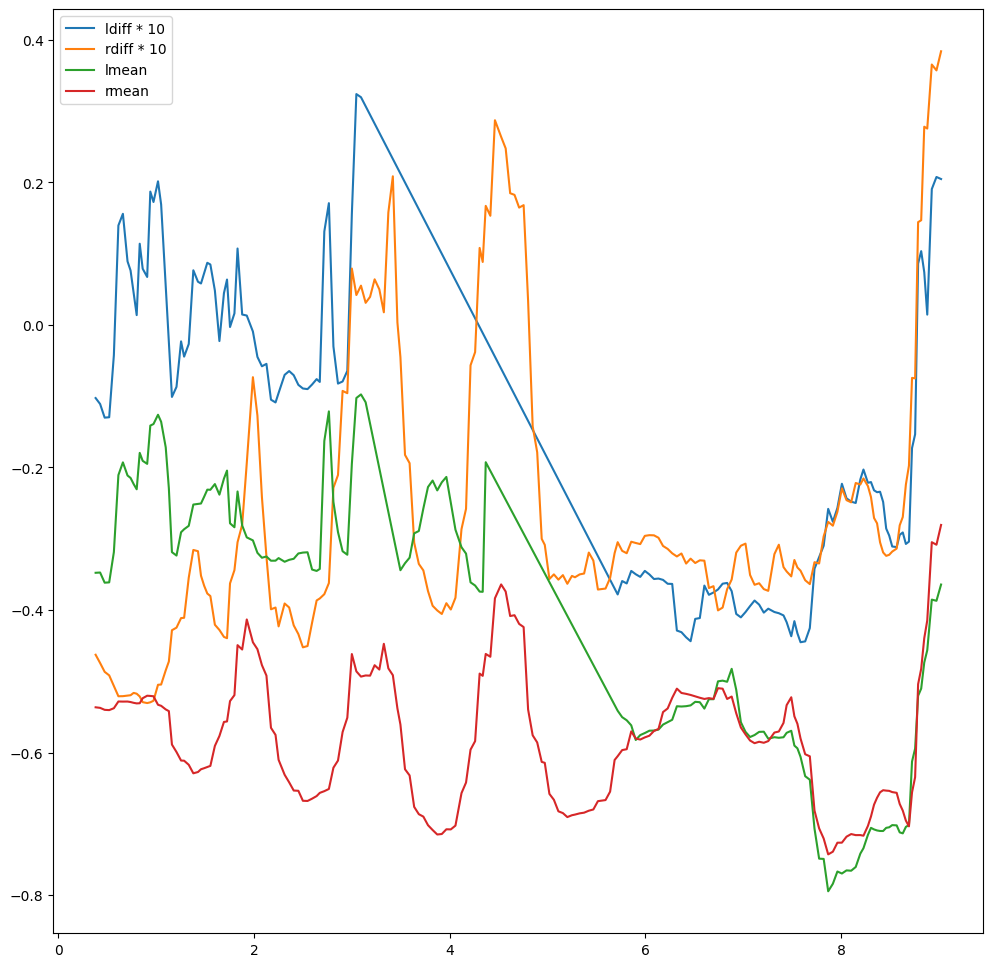

In [56]:
plt.figure(figsize=(12, 12))
X, Y = plot_seq(data, "global", get_diff_and_all_mean, ["ldiff * 10", "rdiff * 10", "lmean", "rmean"])

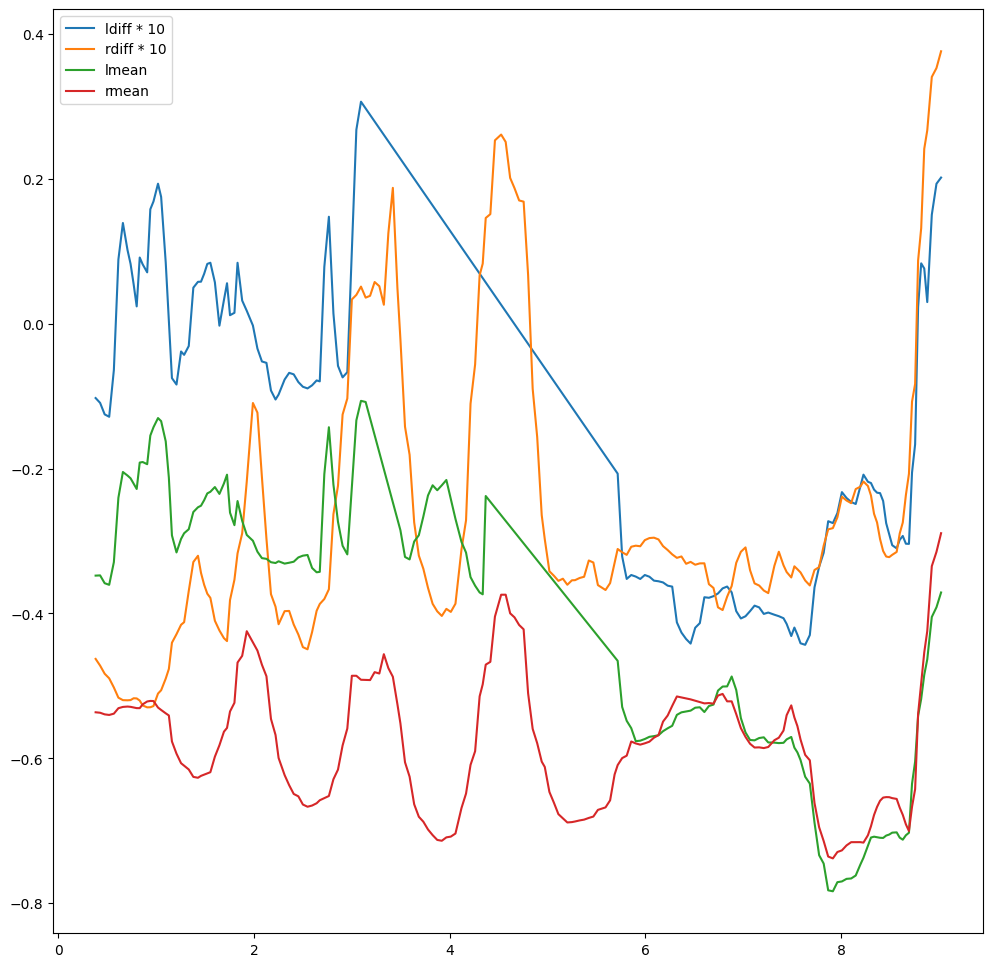

In [72]:
alpha = 0.75
legends = ["ldiff * 10", "rdiff * 10", "lmean", "rmean"]

plt.figure(figsize=(12, 12))
for i in range(len(X)):
    dfff = pd.DataFrame(np.array([X[i], Y[i]]).T, columns=["Time", "Val"])
    dfff['ewm'] = dfff['Val'].ewm(alpha=alpha).mean()
    
    plt.plot(dfff["Time"], dfff['ewm'], label=legends[i])
plt.legend()
plt.show()

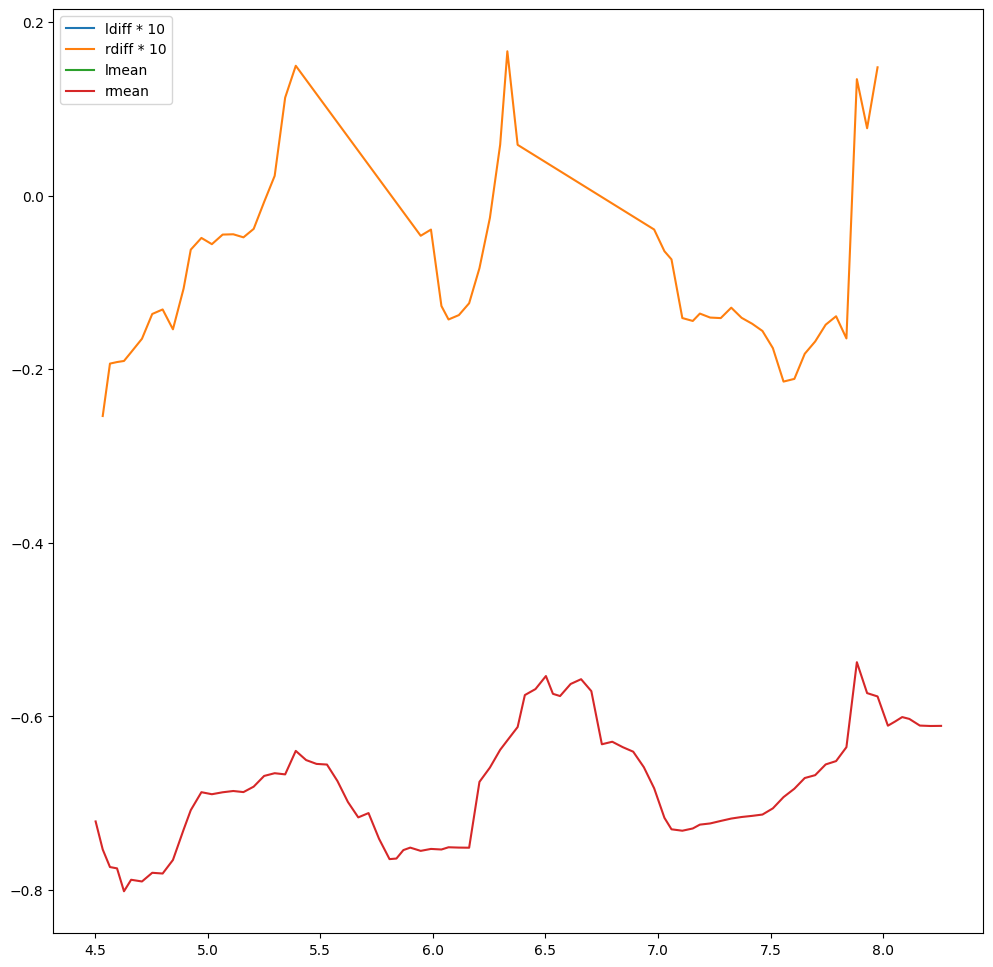

In [74]:
plt.figure(figsize=(12, 12))
_, _ = plot_seq(data1, "global", get_diff_and_all_mean, ["ldiff * 10", "rdiff * 10", "lmean", "rmean"])